# Feature selection

### Dependencies

In [68]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import product
from scipy.stats import spearmanr

from sklearn.model_selection import train_test_split
from sklearn.model_selection import PredefinedSplit
pd.set_option('display.max_columns', 500)
plt.rcParams["figure.figsize"] = (10,7)

import sys
sys.path.append('../')

from src.utils import read_pickle, save_to_pickle

### Loading data

In [69]:
df = pd.read_csv("../data/df_target.csv")

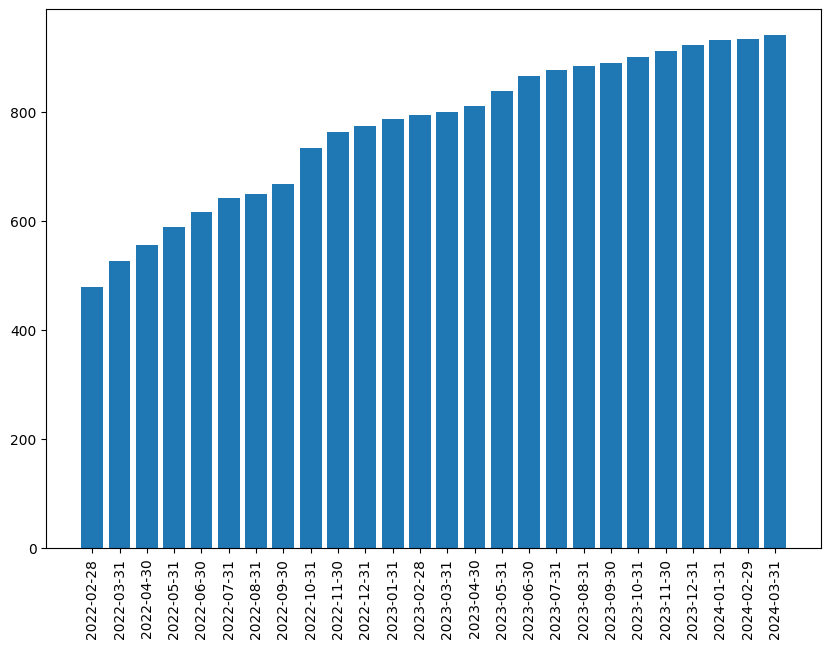

,date,counting,cumulated_rows
0,2022-02-28,479,0.023851
1,2022-03-31,526,0.050042
2,2022-04-30,556,0.077727
3,2022-05-31,589,0.107056
4,2022-06-30,616,0.137728
5,2022-07-31,642,0.169696
6,2022-08-31,650,0.202061
7,2022-09-30,667,0.235274
8,2022-10-31,733,0.271772
9,2022-11-30,763,0.309764


In [70]:
data = df.groupby("date").size()
fig, ax = plt.subplots()
ax.bar(data.index, data)
ax.tick_params(axis='x', labelrotation=90)
plt.show()

data = data.reset_index(name="counting")
data["cumulated_rows"] = data["counting"].cumsum() / data["counting"].sum()
display(data)

In [71]:
mask_train = df["date"] <= "2024-01-31"
df_train = df[mask_train].copy()
df_dev_test = df[~mask_train].copy()

### Dev and test sets

In [72]:
key_columns = ["date", "card_number"]
target_column = "amount_spent_1m"
all_columns = df.columns.tolist()

predictor_columns = [col for col in all_columns if col not in [target_column] + key_columns]

X_dev_test = df_dev_test[predictor_columns]
y_dev_test = df_dev_test[target_column].values

X_dev, X_test, y_dev, y_test = train_test_split(
    X_dev_test, y_dev_test, test_size=0.50, random_state=42)

X_train = df_train[predictor_columns]
y_train = df_train[target_column].values

In [73]:
len(X_train), len(X_dev), len(X_test)

(18208, 937, 938)

### Feature selection

In [74]:
X_train.isna().mean().sort_values()

count_acivico                                                 0.0
sum_original_gross_amt_inclusive_growth                       0.0
sum_original_gross_amt_neighbourhoods                         0.0
sum_original_gross_amt_partnership_insight_and_prevention     0.0
sum_original_gross_amt_place_prosperity_and_sustainability    0.0
                                                             ... 
sum_original_gross_amt_commonwealth_games                     0.0
sum_original_gross_amt_council_management                     0.0
sum_original_gross_amt_cypandf                                0.0
count_partnership_insight_and_prevention                      0.0
amount_spent                                                  0.0
Length: 62, dtype: float64

In [75]:
# coeficiente de variacion
# eliminamos variables con baja variación (< 1)

df_std = X_train.std()
df_mean = X_train.mean()

df_coef_var = df_std / df_mean

df_coef_var.sort_values().head(10)

days_since_last_purchase          1.671080
count_7                           2.619698
count_schools                     2.749101
count_9                           2.822897
count_4                           2.908347
sum_original_gross_amt_schools    3.264832
count_8                           3.376765
count_2                           3.640143
sum_original_gross_amt_3          3.721572
count_5                           3.827833
dtype: float64

In [76]:
# correlación de spearman con el target

sp_corr = []

for col in predictor_columns:
    x = X_train[col].values
    corr, p_value = spearmanr(x, y_train)
    sp_corr.append((col, corr, p_value))

In [77]:
df_sp_corr = pd.DataFrame(sp_corr, columns=["predictor", "corr", "pvalue"])

In [78]:
df_sp_corr.sort_values("pvalue", inplace=True)

In [79]:
df_sp_corr.to_csv("../data/sp_corr.csv", index=False)

In [80]:
predictor_columns_2 = df_sp_corr.query("pvalue <= 0.001")["predictor"].tolist()

In [81]:
len(predictor_columns_2)

40

In [83]:
predictor_columns_2

['amount_spent',
 'sum_original_gross_amt_schools',
 'count_1',
 'count_2',
 'count_3',
 'count_4',
 'count_5',
 'count_6',
 'count_schools',
 'count_7',
 'count_8',
 'count_9',
 'days_since_last_purchase',
 'sum_original_gross_amt_1',
 'sum_original_gross_amt_2',
 'sum_original_gross_amt_3',
 'sum_original_gross_amt_4',
 'sum_original_gross_amt_5',
 'sum_original_gross_amt_6',
 'sum_original_gross_amt_7',
 'sum_original_gross_amt_8',
 'sum_original_gross_amt_9',
 'sum_original_gross_amt_neighbourhoods',
 'count_neighbourhoods',
 'sum_original_gross_amt_city_operations',
 'count_city_operations',
 'count_0',
 'sum_original_gross_amt_0',
 'count_education_and_skills',
 'sum_original_gross_amt_education_and_skills',
 'sum_original_gross_amt_finance_and_governance',
 'count_finance_and_governance',
 'sum_original_gross_amt_digital_and_customer_services',
 'count_digital_and_customer_services',
 'sum_original_gross_amt_adult_social_care',
 'count_adult_social_care',
 'sum_original_gross_am

### Saving Data

In [82]:
df_train = X_train[predictor_columns_2].copy()
df_train[target_column] = y_train
df_train.to_csv("../data/df_train.csv", index=False)

df_dev = X_dev[predictor_columns_2].copy()
df_dev[target_column] = y_dev
df_dev.to_csv("../data/df_dev.csv", index=False)

df_test = X_test[predictor_columns_2].copy()
df_test[target_column] = y_test
df_test.to_csv("../data/df_test.csv", index=False)